In [ ]:
import numpy as np
from collections import Counter

In [ ]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [ ]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [ ]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

In [ ]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [ ]:
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [ ]:
from sklearn import datasets

In [ ]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred)/len(y_true)
  return accuracy

In [ ]:
data = datasets.load_breast_cancer()

In [ ]:
X = data.data
y = data.target

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [ ]:
clf = RandomForest(n_trees = 3)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_train)
acc = accuracy(y_train, y_pred)

In [ ]:
acc

0.989010989010989

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

In [ ]:
acc

0.9824561403508771

In [ ]:
clf = DecisionTree(max_depth = 10)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_train)
acc = accuracy(y_train, y_pred)
acc

1.0

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
acc

0.9736842105263158

In [ ]:
from google.colab import files
files.upload()

Saving titanic.csv to titanic.csv


{'titanic.csv': b'"pclass","survived","name","sex","age","sibsp","parch","ticket","fare","cabin","embarked","boat","body","home.dest"\n1,1,"Allen, Miss. Elisabeth Walton","female",29,0,0,"24160",211.3375,"B5","S","2",?,"St Louis, MO"\n1,1,"Allison, Master. Hudson Trevor","male",0.9167,1,2,"113781",151.55,"C22 C26","S","11",?,"Montreal, PQ / Chesterville, ON"\n1,0,"Allison, Miss. Helen Loraine","female",2,1,2,"113781",151.55,"C22 C26","S",?,?,"Montreal, PQ / Chesterville, ON"\n1,0,"Allison, Mr. Hudson Joshua Creighton","male",30,1,2,"113781",151.55,"C22 C26","S",?,135,"Montreal, PQ / Chesterville, ON"\n1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","female",25,1,2,"113781",151.55,"C22 C26","S",?,?,"Montreal, PQ / Chesterville, ON"\n1,1,"Anderson, Mr. Harry","male",48,0,0,"19952",26.55,"E12","S","3",?,"New York, NY"\n1,1,"Andrews, Miss. Kornelia Theodosia","female",63,1,0,"13502",77.9583,"D7","S","10",?,"Hudson, NY"\n1,0,"Andrews, Mr. Thomas Jr","male",39,0,0,"112050",0,"A36","S",

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_csv("titanic.csv")

In [ ]:
df.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48,0,0,19952,26.55,E12,S,3,?,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63,1,0,13502,77.9583,D7,S,10,?,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39,0,0,112050,0,A36,S,?,?,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53,2,0,11769,51.4792,C101,S,D,?,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71,0,0,PC 17609,49.5042,?,C,?,22,"Montevideo, Uruguay"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


In [ ]:
df.replace('?',np.nan,inplace=True)

In [ ]:
df.isna()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,False,False,False,False,False,False,False,False,False,True,False,True,False,True
1305,False,False,False,False,True,False,False,False,False,True,False,True,True,True
1306,False,False,False,False,False,False,False,False,False,True,False,True,False,True
1307,False,False,False,False,False,False,False,False,False,True,False,True,True,True


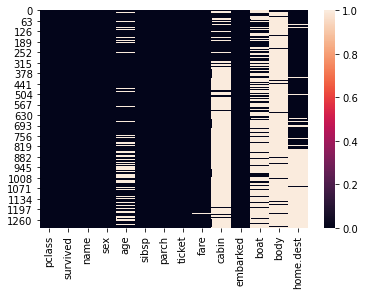

In [ ]:
sns.heatmap(df.isna())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1046 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1308 non-null   object
 9   cabin      295 non-null    object
 10  embarked   1307 non-null   object
 11  boat       486 non-null    object
 12  body       121 non-null    object
 13  home.dest  745 non-null    object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


In [ ]:
dropping=['cabin','boat','body','home.dest']
for i in dropping:
    df.drop(i,axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    1309 non-null   int64 
 1   survived  1309 non-null   int64 
 2   name      1309 non-null   object
 3   sex       1309 non-null   object
 4   age       1046 non-null   object
 5   sibsp     1309 non-null   int64 
 6   parch     1309 non-null   int64 
 7   ticket    1309 non-null   object
 8   fare      1308 non-null   object
 9   embarked  1307 non-null   object
dtypes: int64(4), object(6)
memory usage: 102.4+ KB


In [ ]:
df['age']

0           29
1       0.9167
2            2
3           30
4           25
         ...  
1304      14.5
1305       NaN
1306      26.5
1307        27
1308        29
Name: age, Length: 1309, dtype: object

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
impu = SimpleImputer()

In [ ]:
df['age']= impu.fit_transform(df['age'].values.reshape(-1,1))

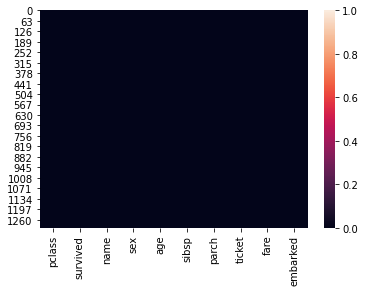

In [ ]:
sns.heatmap(df.isna())

In [ ]:
df.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.55,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.55,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.55,S
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.55,S
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,S
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0,S
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,S
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,C


In [ ]:
df['pclass'].value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

In [ ]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'embarked'],
      dtype='object')

In [ ]:
df['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

In [ ]:
df.drop('name',axis=1,inplace=True)

In [ ]:
df['sex'].value_counts()

male      843
female    466
Name: sex, dtype: int64

In [ ]:
cols=['sibsp', 'parch', 'ticket','fare', 'embarked']
for i in cols:
    print(i," : ",df[i].value_counts())

sibsp  :  0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64
parch  :  0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: parch, dtype: int64
ticket  :  CA. 2343         11
CA 2144           8
1601              8
347077            7
S.O.C. 14879      7
                 ..
347743            1
SC/PARIS 2131     1
350050            1
C.A. 42795        1
349244            1
Name: ticket, Length: 929, dtype: int64
fare  :  8.05       60
13         59
7.75       55
26         50
7.8958     49
           ..
9.8375      1
8.3         1
12          1
7.2833      1
10.5167     1
Name: fare, Length: 281, dtype: int64
embarked  :  S    914
C    270
Q    123
Name: embarked, dtype: int64


In [ ]:
df.drop('ticket',axis=1,inplace=True)

In [ ]:
df.dropna(axis=0,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1306 non-null   int64  
 1   survived  1306 non-null   int64  
 2   sex       1306 non-null   int64  
 3   age       1306 non-null   float64
 4   sibsp     1306 non-null   int64  
 5   parch     1306 non-null   int64  
 6   fare      1306 non-null   float64
 7   embarked  1306 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 91.8+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df['fare']= df['fare'].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1306 non-null   int64  
 1   survived  1306 non-null   int64  
 2   sex       1306 non-null   int64  
 3   age       1306 non-null   float64
 4   sibsp     1306 non-null   int64  
 5   parch     1306 non-null   int64  
 6   fare      1306 non-null   float64
 7   embarked  1306 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 91.8+ KB


In [ ]:
cat=['sex','embarked']

In [ ]:
for i in cat:
    le= LabelEncoder()
    df[i]= le.fit_transform(df[i])

In [ ]:
from sklearn.preprocessing import minmax_scale

In [ ]:
num=['age','fare']
for i in num:
    df[i]= minmax_scale(df[i])

In [ ]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,0.361169,0,0,0.412503,2
1,1,1,1,0.009395,1,2,0.295806,2
2,1,0,0,0.022964,1,2,0.295806,2
3,1,0,1,0.373695,1,2,0.295806,2
4,1,0,0,0.311064,1,2,0.295806,2


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived',axis=1).values, df['survived'].values, test_size=0.25, random_state=123)

In [ ]:
clf = RandomForest(n_trees = 3)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_train)
acc = accuracy(y_train, y_pred)

In [ ]:
acc

0.9278930125782904

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

In [ ]:
acc

0.8725690546810547

In [ ]:
clf = DecisionTree(max_depth = 10)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_train)
acc = accuracy(y_train, y_pred)

In [ ]:
acc

0.8878202567195469

In [ ]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

In [ ]:
acc

0.8377643509723481